# Lab. 7: Bio-Inspired Optimization

## Introduction

#### <u>The goal of this lab is to study different Bio-Inspired Optimization techniques.</u>

**Disclamer**
- When studying the effect of the parameters is extremely important to vary just one parameter at a time. Therefore, you are suggested to study one parameter by fixing all the others, and then moving to the next.

- When comparing different algorithms, is very important to run each of them several times (e.g., 30) by using different initial random seeds.

In [2]:
%%capture
!pip install cma
!pip install inspyred
!pip install benchmark_functions

In [3]:
import cma
import inspyred
import importlib
import functools
import numpy as np
from pylab import *
from inspyred import ec
from copy import deepcopy
from functools import reduce
import benchmark_functions as bf
from matplotlib import pyplot as plt
from inspyred.ec import EvolutionaryComputation
from inspyred.ec import selectors, replacers, terminators
from random import Random

### Helper functions

In [4]:
GLOBAL = 'Global'
INDIVIDUAL = 'Individual'
CORRELATED = 'Correlated'
STAR = 'star'
RING = 'ring'

class OptFun():
    def __init__(self, wf):
        self.f = wf
        self.history = []
        self.__name__ = f'OptFun({wf.__class__})'

    def __call__(self, candidates, *args, **kwargs):
        """
        Evaluate the objective function for a list of candidates.
        """
        y = []
        for x0 in candidates:
            self.history.append(deepcopy(x0))
            y.append(self.f(x0))
        return y

    def minima(self):
        return self.f.minima()

    def bounder(self):
        def fcn(candidate, *args):
            bounds = self.f.suggested_bounds()

            for i, (m, M) in enumerate(zip(*bounds)):
                if candidate[i] < m:
                    candidate[i] = m
                if candidate[i] > M:
                    candidate[i] = M
            return candidate
        return fcn

    def bounds(self):
        """
        Return the bounds of the objective function.
        """
        return self._convert_bounds(self.f.suggested_bounds())

    def heatmap(self, fn = None):
        plt.clf()
        resolution = 50
        fig = plt.figure()
        fig.canvas.manager.set_window_title('Benchmark Function: '+self.f._name)
        fig.suptitle(self.f._name)
        bounds_lower, bounds_upper = self.f.suggested_bounds()
        x = np.linspace(bounds_lower[0], bounds_upper[0], resolution)
        if self.f._n_dimensions>1:
            y = np.linspace(bounds_lower[1], bounds_upper[1], resolution)
            X, Y = np.meshgrid(x, y)
            Z = np.asarray([[self.f((X[i][j],Y[i][j])) for j in range(len(X[i]))] for i in range(len(X))])

        plt.contour(x,y,Z,15,linewidths=0.5,colors='k') # hight lines
        plt.contourf(x,y,Z,15,cmap='viridis', vmin=Z.min(), vmax=Z.max()) # heat map
        plt.xlabel('x')
        plt.ylabel('y')
        cbar = plt.colorbar()
        cbar.set_label('z')
        if len(self.history)>0:	# plot points
            xdata = [x[0] for x in self.history]
            ydata = [x[1] for x in self.history]
            plt.plot(xdata, ydata, "or-", markersize=3, linewidth=1)
        if fn is None:
            plt.show()
        else:
            plt.savefig(fn, dpi=400)

    def plot(self):
        """
        Plot the history of the objective function values.
        """
        plt.clf()
        values = [self.f(v) for v in self.history]
        min_value = self.f.minima()[0].score
        plt.plot(values)
        plt.axhline(min_value, color="r", label="optimum")
        plt.legend(loc="upper right")
        plt.show()

    def _convert_bounds(self, bounds):
        """
        Convert bounds to a list of tuples.
        """
        return [(bounds[0][i], bounds[1][i]) for i in range(len(bounds[0]))]

    def current_calls(self):
        """
        Return the number of calls to the objective function.
        """
        return len(self.history)

In [5]:
def choice_without_replacement(rng, n, size) :
    result = set()
    while len(result) < size :
        result.add(rng.randint(0, n))
    return result

class NumpyRandomWrapper(RandomState):
    def __init__(self, seed=None):
        super(NumpyRandomWrapper, self).__init__(seed)

    def sample(self, population, k):
        if isinstance(population, int) :
            population = range(population)

        return asarray([population[i] for i in
                        choice_without_replacement(self, len(population), k)])

    def random(self):
        return self.random_sample()

    def gauss(self, mu, sigma):
        return self.normal(mu, sigma)

def initial_pop_observer(population, num_generations, num_evaluations,
                         args):
    if num_generations == 0 :
        args["initial_pop_storage"]["individuals"] = asarray([guy.candidate
                                                 for guy in population])
        args["initial_pop_storage"]["fitnesses"] = asarray([guy.fitness
                                          for guy in population])

def generator(random, args):
    return asarray([random.uniform(args["pop_init_range"][0],
                                   args["pop_init_range"][1])
                    for _ in range(args["num_vars"])])

def generator_wrapper(func):
        @functools.wraps(func)
        def _generator(random, args):
            return asarray(func(random, args))
        return _generator

# helper function used to store the various populations at each generation
def my_archiver(random, population, archive, args):
    archive.append(population)
    return archive


def run_ga(random, func, num_vars=0,
           maximize=False, **kwargs) :

    #create dictionaries to store data about initial population, and lines
    initial_pop_storage = {}

    algorithm = ec.EvolutionaryComputation(random)
    algorithm.terminator = ec.terminators.generation_termination
    algorithm.replacer = ec.replacers.generational_replacement
    algorithm.variator = [ec.variators.uniform_crossover,ec.variators.gaussian_mutation]
    algorithm.selector = ec.selectors.tournament_selection
    algorithm.archiver = my_archiver
    algorithm.observer = initial_pop_observer

    kwargs["num_selected"]=kwargs["pop_size"]

    kwargs["bounder"]=func.bounder()
    kwargs["generator"]=generator

    final_pop = algorithm.evolve(evaluator=func,
                          maximize=False,
                          initial_pop_storage=initial_pop_storage,
                          num_vars=num_vars,
                          **kwargs)

    all_populations = algorithm.archive
    for i in range(len(all_populations)):
        all_populations[i] = [elem.candidate for elem in all_populations[i]]

    #best_guy = final_pop[0].candidate
    #best_fitness = final_pop[0].fitness
    final_pop_fitnesses = asarray([guy.fitness for guy in final_pop])
    final_pop_candidates = asarray([guy.candidate for guy in final_pop])

    sort_indexes = sorted(range(len(final_pop_fitnesses)), key=final_pop_fitnesses.__getitem__)
    final_pop_fitnesses = final_pop_fitnesses[sort_indexes]
    final_pop_candidates = final_pop_candidates[sort_indexes]

    best_guy = final_pop_candidates[0]
    best_fitness = final_pop_fitnesses[0]

    return best_guy, best_fitness, final_pop, all_populations


class ES(EvolutionaryComputation):
    """Evolution Strategy EC

    This class is a stub for you to implement progressively more
    sophisticated evolution strategies.

    Optional keyword arguments in ``evolve`` args parameter that you
    will need add support for:

    - *strategy_mode* -- One of {None, 'global', 'individual', 'correlated'}
    - *epsilon* -- the minimum allowed strategy parameter (default 0.00001)
    - *tau* -- a global proportionality constant (default None)
    - *tau_i* -- an individual proportionality constant (default None)
    - *num_offspring* -- number of offspring to generate at each iteration
                        (``\\lambda``) should be a multiple of \\mu
    - *mixing_number* -- mixing number (``\\rho``) (number of parents
                        involved in producing each offspring),
                        default 1 (no-mixing)

    If *tau* is ``None``, it will be set to ``1 / sqrt(2*n)``, where
    ``n`` is the length of a candidate. If *tau_i* is ``None``, it will be
    set to ``1 / sqrt(2*sqrt(n))``.

    """
    def __init__(self, random):
        EvolutionaryComputation.__init__(self, random)
        self.selector = selectors.default_selection
        self.variator = self._internal_variation
        #self.replacer = replacers.comma_replacement
        self.replacer = replacers.plus_replacement

    def elementary_rotation(self, p, q, alphas):
        R = ones((self.num_vars, self.num_vars))

        # taken from Schwefel et al "Contemporary Evolution Strategies"
        k = int(0.5 * (2*self.num_vars - p - 1) * (p + 2) -
                2*self.num_vars + q)
        cos_alpha = cos(alphas[k])
        sin_alpha = sin(alphas[k])
        R[p][p] = cos_alpha
        R[q][q] = cos_alpha
        R[p][q] = -sin_alpha
        R[q][p] = sin_alpha
        return R

    def _internal_variation(self, random, candidates, args):
        tau = args.setdefault('tau', None)
        tau_i = args.setdefault('tau', None)
        epsilon = args.setdefault('epsilon', 0.00001)

        # num_offspring (\\lambda)
        num_offspring = args.setdefault('num_offspring', len(candidates))

        mixing_number = args.setdefault('mixing_number', 1)

        if num_offspring % len(candidates) != 0 :
            raise Exception("num_offspring (\\lambda) should be a multiple " +
                            "of pop_size (\\mu)")

        mutants = []

        if tau is None:
            tau = 1. / sqrt(2 * self.num_vars)
        if tau_i is None:
            tau_i = 1. / sqrt(2 * sqrt(self.num_vars))

        while len(mutants) < num_offspring :
            parent_family_indices = random.sample([*range(len(candidates))],
                                                   mixing_number)
            parent_family = asarray([candidates[i] for i in
                                     parent_family_indices])
            parent = parent_family.mean(0)

            cand = parent[:self.num_vars].copy()
            if self.strategy_mode is None :
                strat = []
                sigma = args.setdefault('sigma', 1.0)
                if  isinstance(random, NumpyRandomWrapper) :
                    cand += random.normal(0, sigma, cand.shape)
                else :
                    for i,c in enumerate(cand) :
                        cand[i] = c + random.gauss(0, sigma)

            else :
                strat = parent[self.num_vars:].copy()

                if self.strategy_mode is GLOBAL :
                    sigmas = strat
                else :
                    sigmas = strat[:self.num_vars] #view into strat

                e_global = tau * random.gauss(0, 1)

                # more efficient with sumpy
                if  isinstance(random, NumpyRandomWrapper) :
                    sigmas *= exp(e_global + tau_i
                                  * random.normal(0, 1, sigmas.shape))
                    sigmas = maximum(sigmas, epsilon)
                else :
                    for i, s in enumerate(sigmas):
                        sigmas[i] = s * exp(e_global +
                                            tau_i * random.gauss(0, 1))
                        sigmas[i] = max(strat[i], epsilon)

                if self.strategy_mode is CORRELATED :
                    alphas = strat[self.num_vars:] #another view into strat
                    beta_squared = (5.*pi/180) ** 2 # 5 deg squared
                    if  isinstance(random, NumpyRandomWrapper) :
                        alphas += (random.normal(0,beta_squared,
                                                          alphas.shape)
                                          + pi)
                        alphas %= (2*pi)
                        alphas -= pi
                    else :
                        for j,a in enumerate(alphas) :
                            alphas[j] = ((a + random.gauss(0,beta_squared)
                                          + pi) % (2*pi)) - pi

                if self.strategy_mode is GLOBAL :
                    sigma = sigmas[0]
                    if  isinstance(random, NumpyRandomWrapper) :
                        cand = cand + random.normal(0, sigma, cand.shape)
                    else :
                        for i,c in enumerate(cand) :
                            cand[i] = c + random.gauss(0, sigma)
                elif self.strategy_mode is INDIVIDUAL :
                    if  isinstance(random, NumpyRandomWrapper) :
                        cand += random.multivariate_normal(
                                            zeros(self.num_vars),
                                            diag(sigmas**2))
                    else :
                        for i, (c, s) in enumerate(zip(cand, sigmas)):
                            cand[i] = c + random.gauss(0, s)
                else :
                    # build correlation matrix
                    T = reduce(dot,
                           [reduce(dot,
                                  [self.elementary_rotation(p,q,alphas)
                                   for q in range(p+1, self.num_vars)])
                            for p in range(self.num_vars - 1)])
                    if  isinstance(random, NumpyRandomWrapper) :
                        cand += random.multivariate_normal(
                                            zeros(self.num_vars),
                                            dot(T,diag(sigmas**2)))
                    else :
                        raise Exception("NumpyRandomWrapper required" +
                                        " for correlated mutations")

            cand = self.bounder(cand, args)
            cand = np.concatenate((cand, strat))
            mutants.append(cand)

        return mutants

    def _internal_evaluator(self, func):
        @functools.wraps(func)
        def evaluator(candidates, args):
            # convert candidates to array and then back to list
            # makes slicing easier
            return func(list(asarray(candidates)[:,0:self.num_vars]), args)
        return evaluator

    def strategize(self, generator):
        """Add strategy parameters to candidates created by a generator.

        This function decorator is used to provide a means of adding strategy
        parameters to candidates created by a generator. The generator function
        is modifed to extend the candidate with strategy parameters based on
        the strategy_mode argument passed to evolve.

        Each strategy parameter is initialized to a random value:
        in [0, 1] for ``\\sigma_i`` and in [-pi,pi] for ``\\alpha_i``

        """
        @functools.wraps(generator)
        def strategy_generator(random, args):
            candidate = generator(random, args)
            if self.strategy_mode is None :
                return candidate
            elif self.strategy_mode is GLOBAL :
                return np.concatenate( (candidate, [random.random()]) )
            else :
                sigmas = [random.random() for _ in range(self.num_vars)]
                if self.strategy_mode is INDIVIDUAL :
                    return np.concatenate( (candidate, sigmas) )
                elif self.strategy_mode is CORRELATED :
                    # since have python random, do it like this... would be
                    # better with numpy
                    alphas = [random.uniform(-pi, pi)
                              for _ in range((self.num_vars**2 -
                                              self.num_vars)//2)]
                    return np.concatenate( (candidate, alphas, sigmas) )

        return strategy_generator

    def evolve(self, generator, evaluator, pop_size=100, seeds=None,
               maximize=False, bounder=None, strategy_mode=None, num_vars=None,
               **args):
        self.strategy_mode = strategy_mode
        self.num_vars = num_vars

        generator = self.strategize(generator)
        evaluator = self._internal_evaluator(evaluator)
        return EvolutionaryComputation.evolve(self, generator, evaluator,
                                              pop_size, maximize=maximize,
                                              num_vars=num_vars,
                                              bounder=bounder, **args)


def run_es(random, func, num_vars=0,
           maximize=False, **kwargs) :

    #create dictionaries to store data about initial population, and lines
    initial_pop_storage = {}

    algorithm = ES(random)
    algorithm.terminator = terminators.generation_termination

    algorithm.observer = initial_pop_observer
    algorithm.archiver = my_archiver

    kwargs["num_selected"]=kwargs["pop_size"]
    kwargs["bounder"]=func.bounder()
    kwargs["generator"]=generator_wrapper(generator)

    final_pop = algorithm.evolve(evaluator=func,
                          maximize=maximize,
                          initial_pop_storage=initial_pop_storage,
                          num_vars=num_vars,
                          **kwargs)
    all_populations = algorithm.archive
    for i in range(len(all_populations)):
        all_populations[i] = [elem.candidate for elem in all_populations[i]]

    #best_guy = final_pop[0].candidate[0:num_vars]
    #best_fitness = final_pop[0].fitness
    final_pop_fitnesses = asarray([guy.fitness for guy in final_pop])
    final_pop_candidates = asarray([guy.candidate[0:num_vars] for guy in final_pop])

    sort_indexes = sorted(range(len(final_pop_fitnesses)), key=final_pop_fitnesses.__getitem__)
    final_pop_fitnesses = final_pop_fitnesses[sort_indexes]
    final_pop_candidates = final_pop_candidates[sort_indexes]

    best_guy = final_pop_candidates[0]
    best_fitness = final_pop_fitnesses[0]

    return best_guy, best_fitness, final_pop, all_populations

# This class inherit from the original inspyred.swarm.PSO class to allow archive
# of all the populations at each generation
class PSO(inspyred.swarm.PSO):
    def _swarm_archiver(self, random, population, archive, args):
        self.swarm_archive.append(population)
        if len(archive) == 0:
            return population[:]
        else:
            new_archive = []
            for i, (p, a) in enumerate(zip(population[:], archive[:])):
                if p < a:
                    new_archive.append(a)
                else:
                    new_archive.append(p)
            return new_archive

def run_pso(random, func, num_vars=0, maximize=False, **kwargs):

    #create dictionaries to store data about initial population, and lines
    initial_pop_storage = {}

    algorithm = PSO(random)
    algorithm.swarm_archive = []
    algorithm.topology = inspyred.swarm.topologies.star_topology
    algorithm.terminator = ec.terminators.generation_termination

    algorithm.observer = initial_pop_observer

    if "topology" in kwargs :
        if kwargs["topology"] is STAR:
            algorithm.topology = inspyred.swarm.topologies.star_topology
        elif kwargs["topology"] is RING:
            algorithm.topology = inspyred.swarm.topologies.ring_topology

    kwargs["num_selected"]=kwargs["pop_size"]
    kwargs["bounder"]= func.bounder()
    kwargs["generator"]=generator

    final_pop = algorithm.evolve(evaluator=func,
                          maximize=maximize,
                          initial_pop_storage=initial_pop_storage,
                          num_vars=num_vars,
                          **kwargs)

    all_populations = []
    for i in range(len(algorithm.swarm_archive)):
        all_populations.append([elem.candidate for elem in algorithm.swarm_archive[i]])

    final_pop_fitnesses = asarray([guy.fitness for guy in final_pop])
    final_pop_candidates = asarray([guy.candidate for guy in final_pop])

    sort_indexes = sorted(range(len(final_pop_fitnesses)), key=final_pop_fitnesses.__getitem__)
    final_pop_fitnesses = final_pop_fitnesses[sort_indexes]
    final_pop_candidates = final_pop_candidates[sort_indexes]

    best_guy = final_pop_candidates[0]
    best_fitness = final_pop_fitnesses[0]

    return best_guy, best_fitness, final_pop, all_populations

In [6]:
# ---- mine
def run_mutation_only_ga(random, func, num_vars=0, maximize=False, **kwargs):
    # Set the variator to include only the Gaussian mutation operator
    algorithm = ec.EvolutionaryComputation(random)
    algorithm.variator = [ec.variators.gaussian_mutation]
    
    # Run the genetic algorithm
    return run_ga_internal(algorithm, func, num_vars, maximize, **kwargs)

def run_crossover_only_ga(random, func, num_vars=0, maximize=False, **kwargs):
    # Set the variator to include only the uniform crossover operator
    algorithm = ec.EvolutionaryComputation(random)
    algorithm.variator = [ec.variators.uniform_crossover]
    
    # Run the genetic algorithm
    return run_ga_internal(algorithm, func, num_vars, maximize, **kwargs)

def run_ga_internal(algorithm, func, num_vars=0, maximize=False, **kwargs):
    # Create dictionaries to store data about initial population and lines
    initial_pop_storage = {}

    algorithm.terminator = ec.terminators.generation_termination
    algorithm.replacer = ec.replacers.generational_replacement
    algorithm.selector = ec.selectors.tournament_selection
    algorithm.archiver = my_archiver
    algorithm.observer = initial_pop_observer

    kwargs["num_selected"] = kwargs["pop_size"]
    kwargs["bounder"] = func.bounder()
    kwargs["generator"] = generator

    final_pop = algorithm.evolve(evaluator=func,
                                  maximize=maximize,
                                  initial_pop_storage=initial_pop_storage,
                                  num_vars=num_vars,
                                  **kwargs)

    all_populations = algorithm.archive
    for i in range(len(all_populations)):
        all_populations[i] = [elem.candidate for elem in all_populations[i]]

    final_pop_fitnesses = asarray([guy.fitness for guy in final_pop])
    final_pop_candidates = asarray([guy.candidate for guy in final_pop])

    sort_indexes = sorted(range(len(final_pop_fitnesses)), key=final_pop_fitnesses.__getitem__)
    final_pop_fitnesses = final_pop_fitnesses[sort_indexes]
    final_pop_candidates = final_pop_candidates[sort_indexes]

    best_guy = final_pop_candidates[0]
    best_fitness = final_pop_fitnesses[0]

    return best_guy, best_fitness, final_pop, all_populations


In [7]:
def plot_population_evolution(populations, objective_fun, generation_step=1):
    plt.clf()
    resolution = 50
    fig, ax = plt.subplots(2, 3)
    ax = ax.flatten()
    fig.set_figwidth(10)
    fig.set_figheight(7)

    bounds_lower, bounds_upper = objective_fun.f.suggested_bounds()
    x = np.linspace(bounds_lower[0], bounds_upper[0], resolution)
    if objective_fun.f._n_dimensions>1:
        y = np.linspace(bounds_lower[1], bounds_upper[1], resolution)
        X, Y = np.meshgrid(x, y)
        Z = np.asarray([[objective_fun.f((X[i][j],Y[i][j])) for j in range(len(X[i]))] for i in range(len(X))])

    for i in range(min(len(populations),6)):
        if i*generation_step<len(populations):
          ax[i].contour(x,y,Z,15,linewidths=0.5,colors='k')
          ax[i].contourf(x,y,Z,15,cmap='viridis', vmin=Z.min(), vmax=Z.max()) # heat map
          ax[i].set_xlabel('x')
          ax[i].set_ylabel('y')
          ax[i].title.set_text("Generation " + str(i*generation_step))

          # scatter plot of the population
          current_pop = populations[i*generation_step]
          xdata = [x[0] for x in current_pop]
          ydata = [x[1] for x in current_pop]
          ax[i].scatter(xdata, ydata, color="r", zorder=2, label="population")

    handles, labels = ax[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    plt.tight_layout()
    plt.show()

### Exercises

#### Exercise 1/3: Genetic algorithms

1. Compare the results of mutation-only vs crossover-only
2. Fixing the mutation probability, compare different values for the crossover
3. How does the selective pressure (i.e., tournament size) affect the search?
4. Compare the search process on different benchmark functions

In [8]:
args = {}
args["num_vars"] = 2 # Number of dimensions of the search space
args["gaussian_stdev"] = 1.0 # Standard deviation of the Gaussian mutations
args["num_elites"] = 1 # number of elite individuals to maintain in each gen
args["pop_size"] = 20 # population size
args["max_generations"] = 50 # Number of generations of the GA

<Figure size 640x480 with 0 Axes>

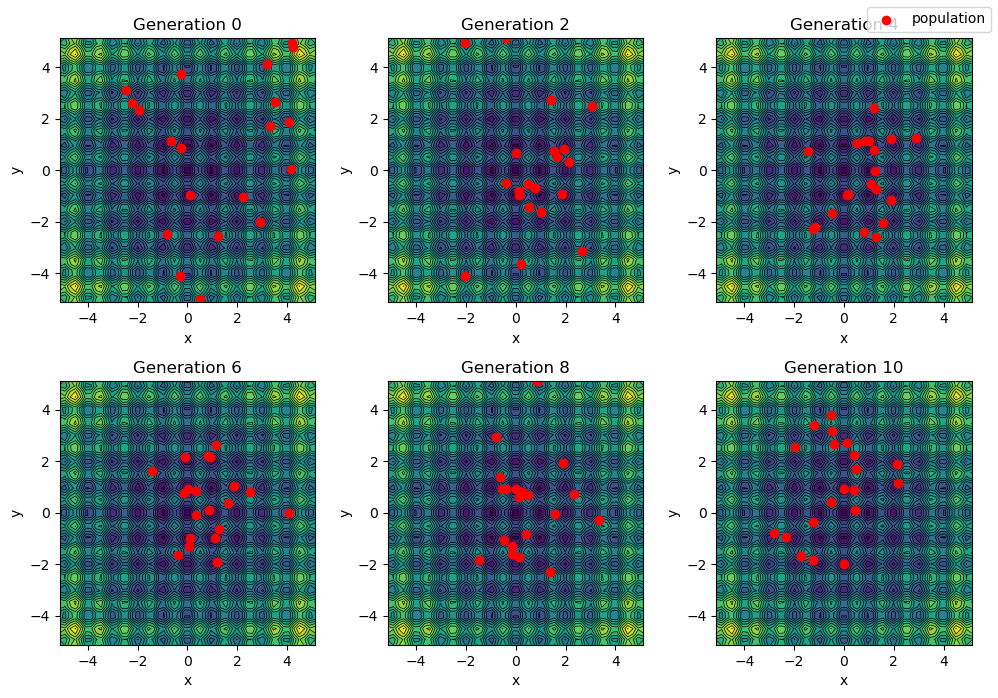

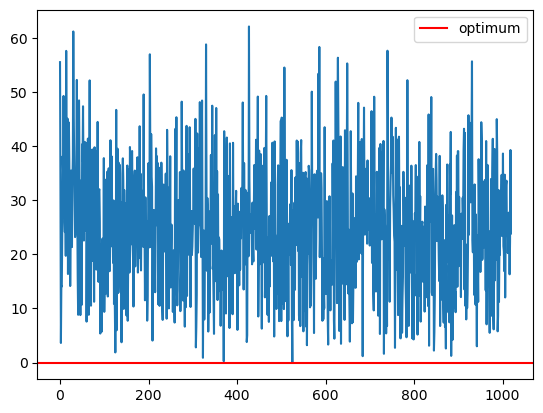

In [9]:
func = OptFun(bf.Rastrigin(2))

# https://www.mdpi.com/2078-2489/10/12/390 => (0.03) mutation rates and (0.9) crossover rates
# Fixing the mutation probability, compare different values for the crossover
args["crossover_rate"] = 0.03 # 0.03
args["mutation_rate"] = 0.9 # 0.9
args["tournament_size"] = 2
args["pop_init_range"] = func.bounds()[0] # Range for the initial population

best_guy, best_fitness, final_pop, all_populations = run_ga( # run_crossover_only_ga / run_mutation_only_ga
    Random(0),  # Seeded random number generator
    func,
    **args
)

plot_population_evolution(all_populations, func, generation_step=2)
func.plot()

#### Exercise 2/3: Evolutionary Strategies

1. How does the number of offspring  λ  parameter affect the search?
2. How does the mixing number  ρ  affect the search?
3. Describe the impact of the different strategies (None/GLOBAL/INDIVIDUAL) on the search process.

<Figure size 640x480 with 0 Axes>

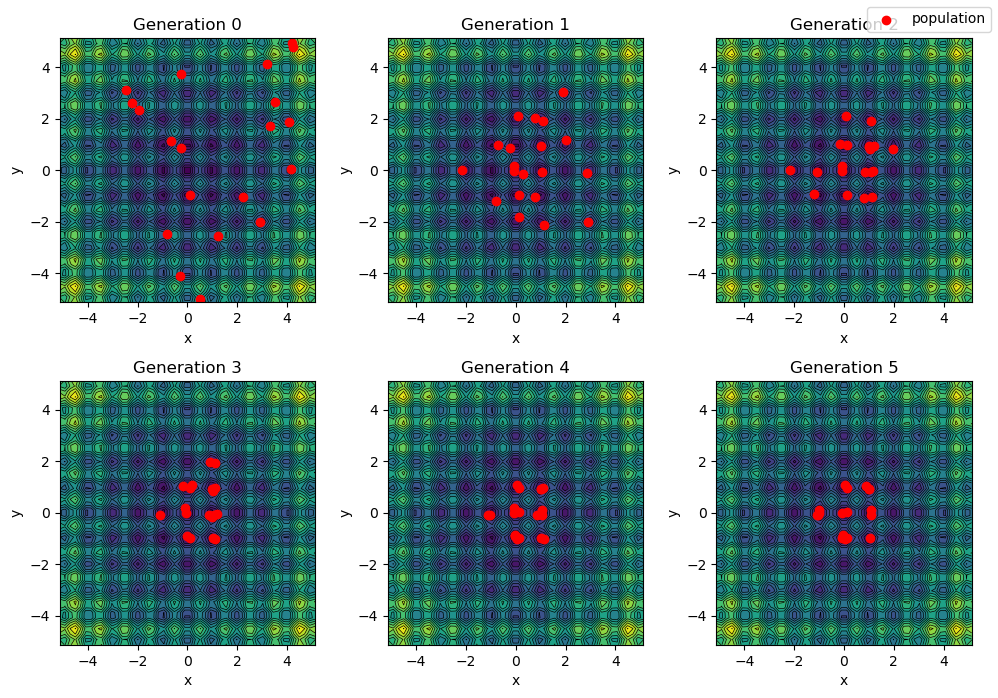

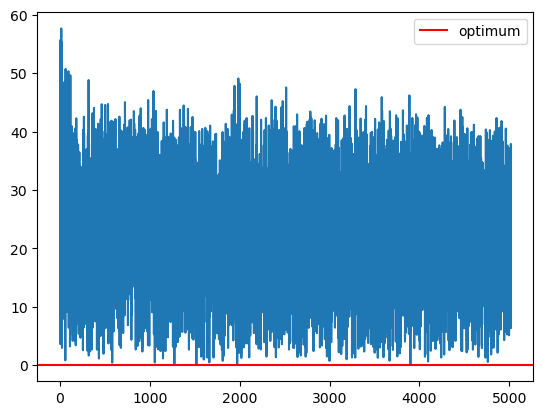

In [10]:
func = OptFun(bf.Rastrigin(2))

args = {}
args["num_vars"] = 2 # Number of dimensions of the search space
args["max_generations"] = 50
args["sigma"] = 1.0 # default standard deviation
args["pop_init_range"] = func.bounds()[0] # Range for the initial population
args["pop_size"] = 20 # mu
args["num_offspring"] = 100 #lambda
args["mixing_number"] = 5 #rho
args["strategy_mode"] = None

best_guy, best_fitness, final_pop, all_populations = run_es(
    Random(0),  # Seeded random number generator
    func,
    **args
)

plot_population_evolution(all_populations, func)
func.plot()

#### Exercise 3/3: Particle Swarm Optimization

1. How does PSO compare to GA on different benchmark functions?
2. How does PSO compare to ES on different benchmark functions?
3. Vary the pop_size and the n. of generations in such a way that their product is always constant, and compare the outcome of the search (over multiple runs). What is better? To have higher pop_size or higher number of generations?

<Figure size 640x480 with 0 Axes>

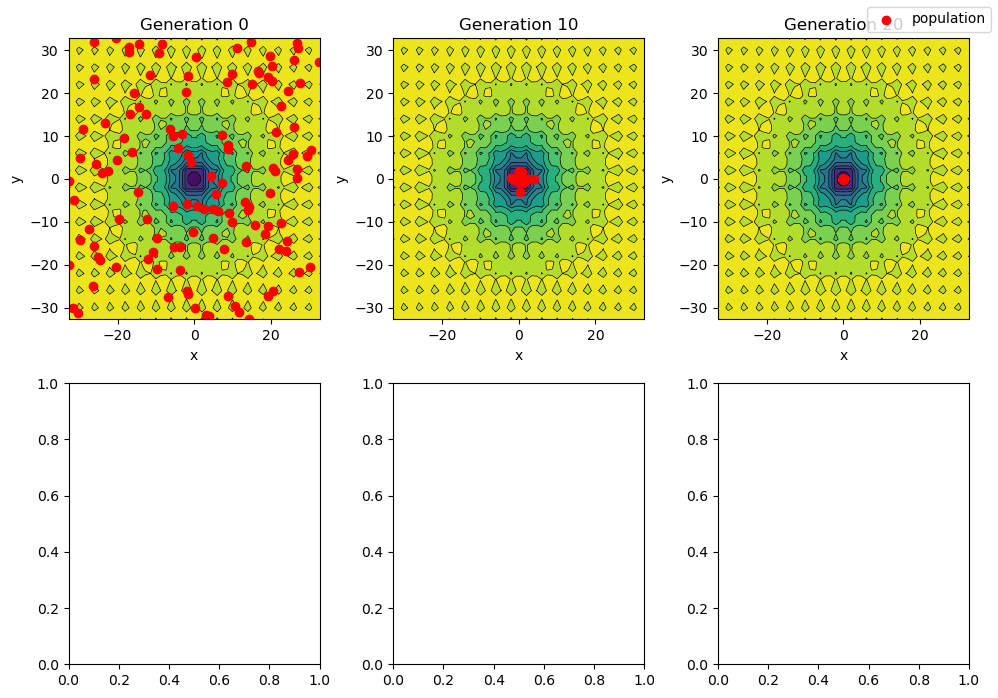

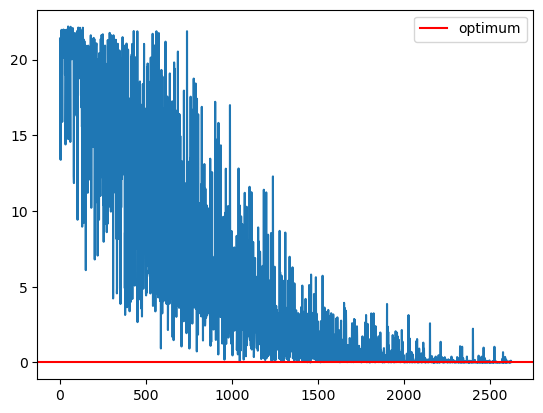

In [18]:
func = OptFun(bf.Ackley(2))

args = {}
args["num_vars"] = 2 # Number of dimensions of the search space
args["pop_init_range"] = func.bounds()[0] # Range for the initial population

args["pop_size"] = 125 #mu
args["topology"] = STAR #RING, STAR
args["neighborhood_size"] = 2   #used only for the ring topology
args["inertia"] = 0.3
args["cognitive_rate"] = 0.5
args["social_rate"] = 2.1
args["max_generations"] = 20

best_guy, best_fitness, final_pop, all_populations = run_pso(
    Random(0),  # Seeded random number generator
    func,
    **args
)

plot_population_evolution(all_populations, func, generation_step=10)
func.plot()